In [37]:
import data
import data_hf
from modelling import model
import jax.numpy as jnp
import jax
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

from importlib import reload
from tqdm import tqdm
model = reload(model)
data = reload(data)
data_hf = reload(data_hf)
import data_shae
data_shae = reload(data_shae)
import finetune
finetune = reload(finetune)
import download_data
download_data = reload(download_data)

import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [41]:
cfg = model.Config(
    d_model=2048,
    ffw_multiplier=4,
    query_heads=8,
    key_heads=8,
    num_layers=12,
    key_dim=128,
    vocab_size=8,
    max_seq_len=8192,
    causal=True,
    use_attn_kernel=False,
    weight_dtype_at_rest=jnp.float32,
    active_weight_dtype=jnp.bfloat16,
    rules=model.mdl_parallel_rules,
    mesh=model.create_mesh(),
    max_lr=3e-5,
    min_lr=3e-6,
    warmup_steps=50,
    total_steps=10000,
)

# Checkpoint manager setup
checkpoint_dir = "gs://minformer_data/finetuned_ckpt/v1"
ckpt_manager = model.make_mngr(path=checkpoint_dir)
weights, opt_state = model.load(ckpt_manager, cfg)
start_step = ckpt_manager.latest_step()

forward = jax.jit(model.forward, static_argnames=['cfg'])

iter = data_shae.create_iterator([f"gs://minformer_data/lab_data_val/tfrecords/" + "record_*.tfrecord"], [], batch_size=1, shuffle=True)

In [58]:
def get_row(cpu_batch):
    row = {
        "sequence": data_shae.detokenize(cpu_batch['x'][0]),
        "sequence_length": len(cpu_batch['x'][0]),
        
        # Use the reverse mappings
        "lad_category": data_shae.LAD_CAT_REV[int(cpu_batch['lad_category'][0][0])],
        "lad_value": float(cpu_batch['lad_value'][0][0]),
        "lad_conserved": bool(cpu_batch['lad_conserved'][0][0]),
        
        "sad_category": data_shae.SAD_CAT_REV[int(cpu_batch['sad_category'][0][0])],
        "sad_value": float(cpu_batch['sad_value'][0][0]),
        "sad_conserved": bool(cpu_batch['sad_conserved'][0]),
        
        "cell_type": data_shae.CELL_REV[int(cpu_batch['cell_type'][0][0])],
        "chromosome": cpu_batch['chromosome'][0][0].decode('utf-8'),
    }
    batch = model.process_batch_shae(cpu_batch, cfg)
    _, internals, _ = forward(batch['x'], batch['segment_ids'], weights, cfg, aux=batch['aux'])
    row['lad_pred'] = jnp.argmax(internals['lad_pred'], -1)
    row['lad_logits'] = jax.nn.softmax(internals['lad_pred'][0])
    row['sad_pred'] = jnp.argmax(internals['sad_pred'], -1)
    row['sad_logits'] = jax.nn.softmax(internals['sad_pred'][0])
    row['lad_value_pred'] = internals['lad_reg']
    row['sad_value_pred'] = internals['sad_reg']
    row['embedding'] = np.array(internals['last_embed'][0, 0, :])

    return row

In [44]:
rows = []
for i in tqdm(range(0, 1000)):
    cpu_batch = next(iter)
    cpu_row = get_row(cpu_batch)
    rows.append(cpu_row)


  0%|                                                                                                                                                                                                                                                                                                             | 0/1000 [00:00<?, ?it/s]

Found 1685 files for stage 1
Found 0 files for stage 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:16<00:00,  5.08it/s]


In [101]:
cpu_batch = next(iter)
batch = model.process_batch_shae(cpu_batch, cfg)
_, internals, _ = forward(batch['x'], batch['segment_ids'], weights, cfg, aux=batch['aux'])

In [104]:
jax.tree.map(jnp.shape, internals)

{'lad_pred': (1, 3),
 'lad_reg': (1,),
 'last_embed': (1, 1, 2048),
 'layers': [{'attn_scores': (1, 8, 8192, 8192)},
  {'attn_scores': (1, 8, 8192, 8192)},
  {'attn_scores': (1, 8, 8192, 8192)},
  {'attn_scores': (1, 8, 8192, 8192)},
  {'attn_scores': (1, 8, 8192, 8192)},
  {'attn_scores': (1, 8, 8192, 8192)},
  {'attn_scores': (1, 8, 8192, 8192)},
  {'attn_scores': (1, 8, 8192, 8192)},
  {'attn_scores': (1, 8, 8192, 8192)},
  {'attn_scores': (1, 8, 8192, 8192)},
  {'attn_scores': (1, 8, 8192, 8192)},
  {'attn_scores': (1, 8, 8192, 8192)}],
 'sad_pred': (1, 3),
 'sad_reg': (1,)}

In [111]:
attn_scores = np.sum(np.concatenate([d['attn_scores'] for d in internals['layers']], 0), axis=(0, 1))

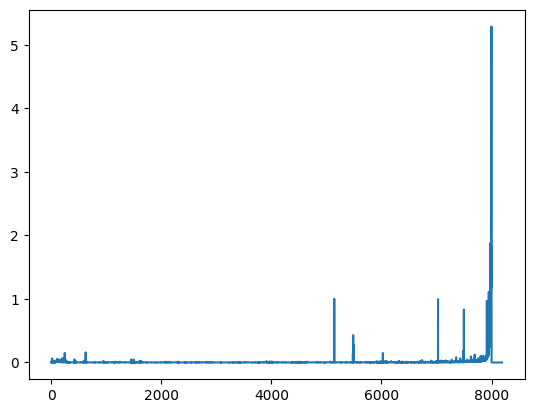

In [116]:
plt.plot(attn_scores[7999, :])

In [61]:
cpu_row = get_row(cpu_batch)

In [62]:
cpu_row

{'sequence': 'TAAATAAGTGCCATCTTTTTGTTTTTATACTGAAAAACAAATGTATCGATTCTCAATTATTTTCTCCCTAATGTAACAATAATAACATAATATTGTATTTTCCAAAACCATTCCTCCTTTCTCTCAATTGTATGTATTTTTCCTTTTTTATTTCTCCTTTTTCTTTTTGGAGCATGATAAATATTTTTAAATCTATCCTCCTGAAATCGCATCTAGGATTTGGGATATATTTTGCCATAAATCTTTGCTTCCTTGGAATAAAAATATTCTCTACATTTTTATTATTCTAATATTGATTCAGCTTTGGAGTTAATTCATATGCAAATCAAATAATTTACCCAAACTTGTAAAGGATATGCATTATCAGAACACAACACCTGCAGGACAAAAGAGAGGTTAATTTCATTGTTGCTCCAAAGCAAAAGGAGATCATTATGGAGCCTGCAGTAACCAAGCTGTGTGAAATAGCTGCATTAGTCATTAACTTTCCAGCACTAAATTTCATATCAAACTCAATTAACTACTACATAGCTTTTAATGACAATATTTTTTCAGATGCAGCTCTTGTTTACTAATAAGATTTCACATCACGACTATCTGTTCCACTACTTCCTCCATGTTAATGAATTCAAGTCTTGATTTTCTCCAAAGAAAATGGGAAAATGAAAATCGCATTTGCTAAAATTCTCCTTGAATTATGTTTTAACATTTCAAGTGTGTTAATGTAATGCTTTAGAAGCTAAAGGGAACGATTATATAGGAAGCTAAAGTCATCTATGTCTATCCTCGGGATTGATTAAGTTTGCTATTTATACATGTTTCCCCCACAACATTGCTGTGTTGGAATTTATCAGGATAGGAACCATCTAAATTGAAAATGCCCCTTCATATATTTTTATCACAGTGAAAGTCAAAGCCTAGAATAACAAAAAGGCACAAAATTAATGTCATCAGGAAACAATTTACTCAGCTAATTAGCATAACAT

In [90]:
df = pd.DataFrame(rows)

In [91]:
df['lad_pred'] = df['lad_pred'].str[0].apply(int)

In [46]:
# Extract embeddings and compute UMAP projection
embeddings = np.stack(df['embedding'].values)
reducer = umap.UMAP(random_state=42)
umap_coords = reducer.fit_transform(embeddings)

/home/sholto/minformer/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


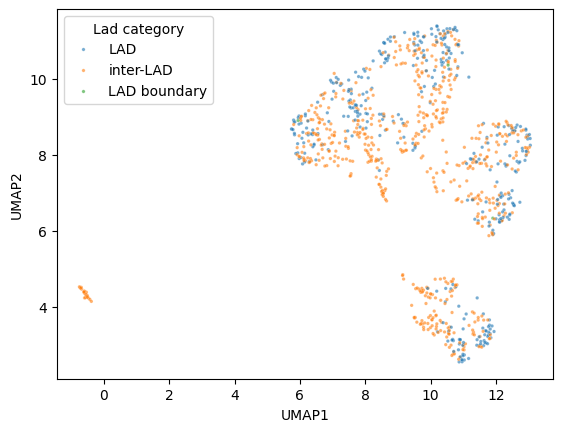

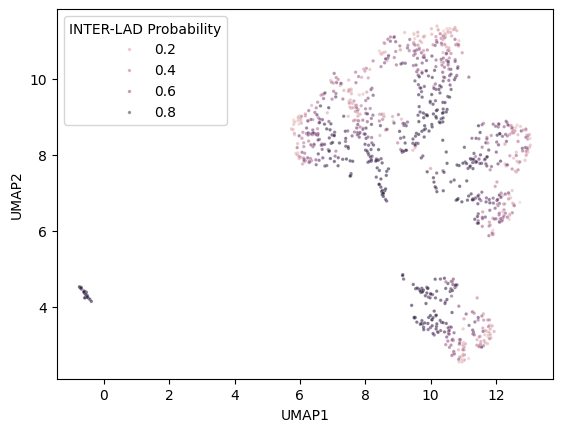

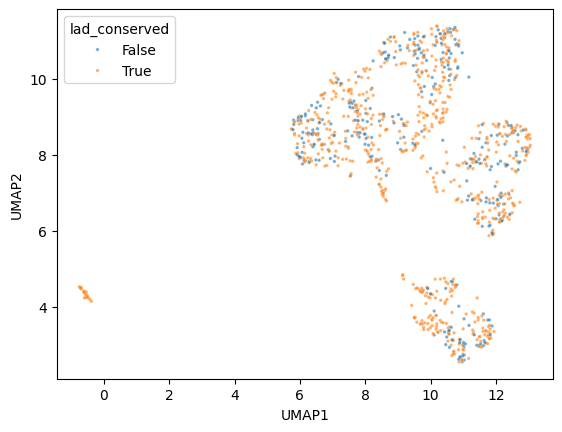

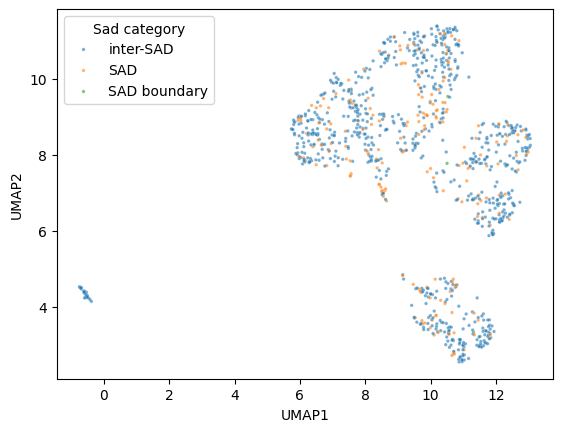

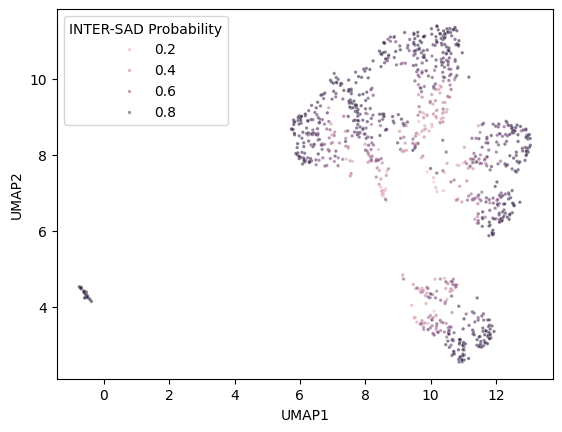

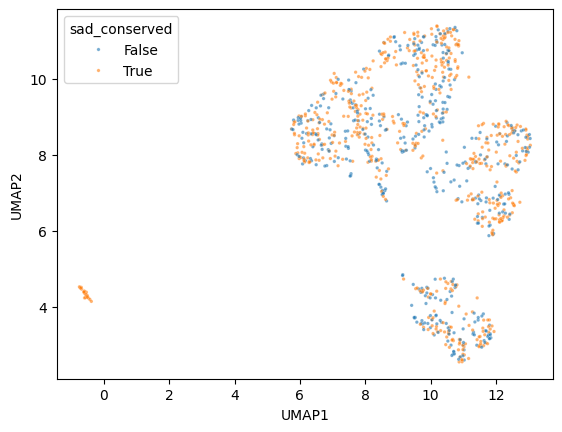

In [103]:
# Create plot
# plt.figure(figsize=(12, 8))
plot_df = pd.DataFrame({
    'UMAP1': umap_coords[:, 0],
    'UMAP2': umap_coords[:, 1],
    'Lad category': df['lad_category'],
    'INTER-LAD Probability': df['lad_logits'].apply(lambda x: float(x[0])),  # Extract first logit
    'lad_conserved': df['lad_conserved'],
    'Sad category': df['sad_category'],
    'INTER-SAD Probability': df['sad_logits'].apply(lambda x: float(x[0])),  # Extract first logit
    'sad_conserved': df['sad_conserved'],
})
sns.scatterplot(data=plot_df, 
                x='UMAP1', 
                y='UMAP2', 
                hue='Lad category',
                alpha=0.6,
                s=6)
plt.show()
sns.scatterplot(data=plot_df, 
                x='UMAP1', 
                y='UMAP2', 
                hue='INTER-LAD Probability',
                alpha=0.6,
                s=6)
plt.show()
sns.scatterplot(data=plot_df, 
                x='UMAP1', 
                y='UMAP2', 
                hue='lad_conserved',
                alpha=0.6,
                s=6)
plt.show()
sns.scatterplot(data=plot_df, 
                x='UMAP1', 
                y='UMAP2', 
                hue='Sad category',
                alpha=0.6,
                s=6)
plt.show()
sns.scatterplot(data=plot_df, 
                x='UMAP1', 
                y='UMAP2', 
                hue='INTER-SAD Probability',
                alpha=0.6,
                s=6)
plt.show()
sns.scatterplot(data=plot_df, 
                x='UMAP1', 
                y='UMAP2', 
                hue='sad_conserved',
                alpha=0.6,
                s=6)
plt.show()

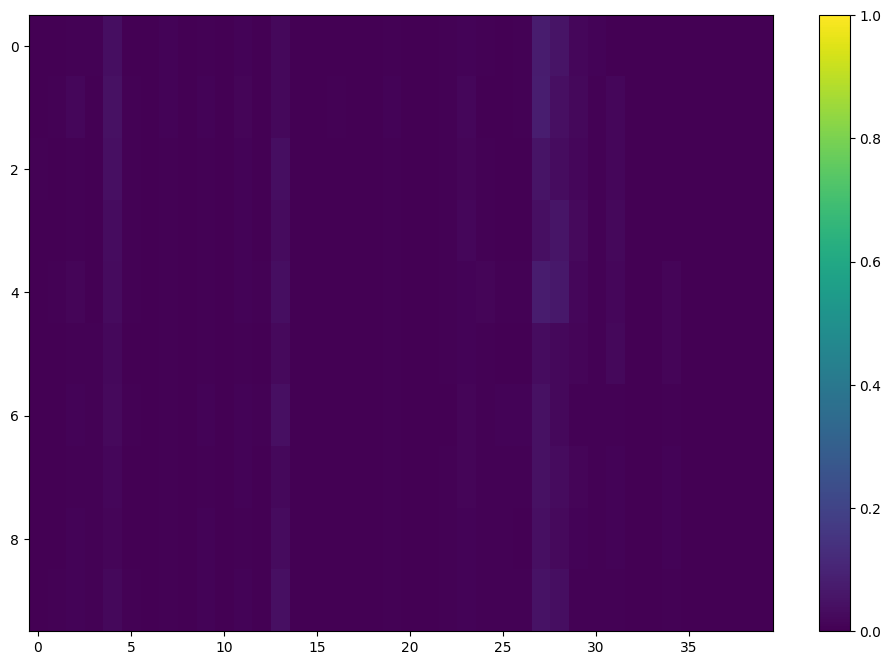

In [123]:
head_idx = 0
plt.figure(figsize=(12, 8))  # Width: 12 inches, Height: 8 inches
plt.imshow(internals['layers'][4]['attn_scores'][0, head_idx, 7990:8000, 7960:8000], 
           cmap='viridis',
           aspect='auto',
           norm=plt.Normalize(vmin=0, vmax=1))  # Normalize the color scale
plt.colorbar()  # Add a colorbar to show the scale

In [97]:
internals['layers'][4]['attn_scores'][0, 1, :, :]

Array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0.806, 0.194, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0.435, 0.263, 0.303, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0.269, 0.155, 0.369, 0.207, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0.216, 0.148, 0.293, 0.254, 0.0896, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

# Lets do some data processing

In [47]:
bucket_name = "minformer_data"
intermediate_progenitor = f"eukaryote_pands/8kb_genomic_bins_with_sequences_GW17IPC.csv"
excitatory_neuron = f"eukaryote_pands/8kb_genomic_bins_with_sequences_GW17eN.csv"
radial_glia = "eukaryote_pands/8kb_genomic_bins_with_sequences_GW17RG.csv"
ip_df_base = download_data.load_csv_from_gcp_bucket(bucket_name, intermediate_progenitor)
en_df_base = download_data.load_csv_from_gcp_bucket(bucket_name, excitatory_neuron)
rg_df_base = download_data.load_csv_from_gcp_bucket(bucket_name, radial_glia)

Index(['Chrom', 'Start', 'End', 'LMNB1 Cat', 'LMNB1 Signal', 'SON Cat',
       'SON Signal', 'LMNB1 + SON', 'LMNB1 Only', 'SON Only',
       'No Nuclear-Body Association', 'Sequence'],
      dtype='object')
Index(['Chrom', 'Start', 'End', 'LMNB1 Cat', 'LMNB1 Signal', 'SON Cat',
       'SON Signal', 'LMNB1 + SON', 'LMNB1 Only', 'SON Only',
       'No Nuclear-Body Association', 'Sequence'],
      dtype='object')
Index(['Chrom', 'Start', 'End', 'LMNB1 Cat', 'LMNB1 Signal', 'SON Cat',
       'SON Signal', 'LMNB1 + SON', 'LMNB1 Only', 'SON Only',
       'No Nuclear-Body Association', 'Sequence'],
      dtype='object')


In [49]:
# Create chr19 validation set
chr19_combined = pd.concat([chr19_ip, chr19_en, chr19_rg], ignore_index=True)
chr19_combined = chr19_combined.sample(frac=1, random_state=42).reset_index(drop=True)

# Combine into single training and validation sets
train_combined = pd.concat([train_ip, train_en, train_rg], ignore_index=True)
train_combined = train_combined.sample(frac=1, random_state=42).reset_index(drop=True)
val_combined = pd.concat([val_ip, val_en, val_rg], ignore_index=True)
val_combined = val_combined.sample(frac=1, random_state=42).reset_index(drop=True)

In [66]:
data_shae.process_rows(chr19_combined, output_dir=f"gs://minformer_data/lab_data_chr19/tfrecords/", bucket=8192)

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                               | 11033/21984 [02:50<02:49, 64.66it/s]


KeyboardInterrupt: 

In [67]:
len(train_combined)

908922

In [68]:
len(val_combined)

227229

In [28]:
# Combine all dataframes

combined_df = pd.concat([ip_df, en_df, rg_df], ignore_index=True)
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate chromosome 19
chr19_df = combined_df[combined_df['Chrom'] == 'chr19'].copy()
non_chr19_df = combined_df[combined_df['Chrom'] != 'chr19'].copy()

# Split into train/test
train_df, test_df = train_test_split(non_chr19_df, test_size=0.2, random_state=42)

I1026 20:30:34.967891  752429 google_auth_provider.cc:181] Running on GCE, using service account 940527310713-compute@developer.gserviceaccount.com


In [8]:
batch = model.process_batch_shae(next(iter), cfg)

Found 2868 files for stage 1
Found 0 files for stage 2


In [8]:
import functools
step = jax.jit(model.update_step, static_argnames=["cfg", "override_compute_loss_fn"])
step = functools.partial(step, cfg=cfg, override_compute_loss_fn=finetune.compute_loss)

In [4]:
weights = model.Weights.init(cfg, jax.random.PRNGKey(0), cfg.mesh, model.fsdp_rules)
opt_state = model.init_optimizer_state(weights)

In [17]:
batch = model.process_batch_shae(next(iter), cfg, 0)
batch = jax.device_put(batch, model.input_shardings(cfg.mesh, cfg.rules))

In [18]:
batch

{'aux': {'bert_mask': Array([[ True, False, False, False, False,  True, False, False, False,  True, False, False, False, False, False, False,  True, False,  True,  True, False, False, False, False, False, False, False, False, False, False, ..., False, False,  True, False, False, False, False, False, False, False, False, False,  True, False, False, False, False, False,  True, False, False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False, False,  True, False, False, False, False,  True, False,  True, False, False, False, False, False, False, False, False,  True, False, False, ..., False, False, False, False, False,  True,  True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,  True, False, False,  True, False, False, False, False],
         [False, False, False, False,  True, False, False, False, False, False, False, False, False, False, 

In [19]:
step = jax.jit(model.update_step, static_argnames='cfg')
step = step.lower(weights, batch['x'], batch['segment_ids'], batch['y'], opt_state, 0, cfg=cfg, aux=batch['aux']).compile()

In [22]:
from jax.profiler import trace
with trace("/tmp/profile"):
    loss, weights, opt_state, internals = step(weights, batch['x'], batch['segment_ids'], batch['y'], opt_state, 0, aux=batch['aux'])
    loss, weights, opt_state, internals = step(weights, batch['x'], batch['segment_ids'], batch['y'], opt_state, 0, aux=batch['aux'])
    jax.block_until_ready(loss)

In [23]:
# Does loss go down!
for i in range(0, 10000):
    batch = model.process_batch_shae(next(iter), cfg, 0)
    batch = jax.device_put(batch, model.input_shardings(cfg.mesh, cfg.rules))
    loss, weights, opt_state, internals = step(weights, batch['x'], batch['segment_ids'], batch['y'], opt_state, i, aux=batch['aux'])
    print(i, loss, internals['accuracy'])

0 2.7370906 0.14352173
1 2.7834382 0.15569633
2 2.345886 0.19360587
3 1.9194294 0.2645749
4 1.7673976 0.2802138
5 1.7095809 0.27229536
6 1.5978522 0.28031278
7 1.5192686 0.26239732
8 1.4651344 0.26952392
9 1.4670441 0.27793726
10 1.446618 0.2783332
11 1.4317198 0.27655154
12 1.4051127 0.30723548
13 1.4085292 0.2786301
14 1.3990364 0.29892114
15 1.3873334 0.3188162
16 1.4059769 0.29318026
17 1.3847693 0.30040583
18 1.3756051 0.30832428
19 1.3670012 0.31851926
20 1.3524804 0.3305949
21 1.3665587 0.32435912
22 1.3642629 0.33079284
23 1.3697145 0.31198657
24 1.3793343 0.30218747
25 1.3655471 0.31723252
26 1.3606695 0.32623973
27 1.3684692 0.320004
28 1.3774017 0.30238545
29 1.3549788 0.3173315
30 1.362595 0.32099378
31 1.3756984 0.3158468
32 1.3714479 0.3076314
33 1.3572427 0.3178264
34 1.3637003 0.32752648
35 1.350418 0.31950906
36 1.35054 0.3387113
37 1.3542302 0.34019598
38 1.3578069 0.31752947
39 1.3670516 0.3121845
40 1.9891182 0.2986242
41 1.3529141 0.32891223
42 1.3521016 0.33099082

ValueError: One of device_put args was given the sharding of NamedSharding(mesh=Mesh('x': 8), spec=PartitionSpec('x', None)), which implies that the global size of its dimension 0 should be divisible by 8, but it is equal to 2 (full shape: (2, 8192))